# Algoritmos Geneticos para optimizacion continua
<b> Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial 2019-01 </b>


In [1]:
import sys
import time
import random
import numpy as np
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import heapq
import math

## Estructura de individuo 

In [2]:
class Individual(object):   
   
    def __init__(self, chromosome):
            self.chromosome = chromosome[:]
            self.fitness = -1  # -1 indica que el individuo no ha sido evaluado
 
            
    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = random.randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:])
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:])
        return [ind1, ind2]   

    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        for i in range(len(self.chromosome)):
            if random.uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1)
        ind2 = Individual(chromosome2)
        return [ind1, ind2] 
  

    def mutate_position(self): 
        """       mutate position
        Cambia aleatoriamente un alelo de un gen."""
        intensity_mutation = 0.1  # intensidad de la mutacion
        mutated_chromosome = deepcopy(self.chromosome)
        mutGene = random.randrange(0,len(mutated_chromosome)) 
        newAllele = mutated_chromosome[mutGene] + random.uniform(-1,1) * intensity_mutation * mutated_chromosome[mutGene] 
        mutated_chromosome[mutGene] = newAllele
        
        return Individual(mutated_chromosome)    
        
    def mutate_allpositions(self):
        "Perturba a todo el cromosoma sumando un vector aleatorio pequeño "
        intensity_mutation = 0.1  # intensidad de la mutacion
        module_chromosome = math.sqrt(sum(i**2 for i in self.chromosome))  # calcula el modulo del cromosoma
        perturbation_vector = [ module_chromosome * intensity_mutation * random.uniform(-1, 1) for j in range(len(self.chromosome))]
        mutated_chromosome =  [sum(x) for x in zip(*[self.chromosome, perturbation_vector])]  # suma el cromosoma con el vector perturbacion 

        return Individual(mutated_chromosome)    


<b> Funcion para iniciar una Poblacion tipo float</b>

In [3]:

def init_population(pop_number, rst):
    population = []
    state_length=2
    ## Crea la poblacion inicial con cromosomas aleatorios
    for i in range(pop_number):
        new_chromosome = [2*rst*random.uniform(0, 1)-rst for j in range(state_length)]
        random.shuffle(new_chromosome)
        population.append(Individual(new_chromosome))

    return population


<b>  Funcion para evaluar toda una población de individuos con la funcion de fitnes especificada </b> 

In [4]:
def evaluate_population(population, fitness_fn):
    """ Evalua una poblacion de individuos con la funcion de fitness pasada """
    
    for i in range(len(population)):
        if population[i].fitness == -1:    # si el individuo no esta evaluado
            population[i].fitness = fitness_fn(population[i].chromosome)
    return population

<b>  Funcion para mostrar una población y su fitnes  </b> 

In [5]:
def display(population):
    listaAG=[]
    for i in range(len(population)):
        listaAG.append([population[i].chromosome,population[i].fitness])

    data=pd.DataFrame(listaAG)
    data.columns = ['Poblacion','fitness']
    return data

## Funciones de Aptitud

In [6]:
def fitness_min(result):  
    # el fitness para fn positivos es trasladado a valores entre [0,1]: 0 para fn=inf y 1 para fn=0. 
    # el fitness para fn negativos es trasladado a valores entre ]1,inf]: 1 para fn=-0 y inf para fn=-inf    
            
    if result >= 0:
        fitness = 1 / (1 + result)
    else:
        fitness =  abs(result)
    return fitness


<b>Funciones de aptitud para evaluar un cromosoma del problema</b>

Ackley’s function
    
    Un problema de minimizacion:

$$f(x_0 \cdots x_n) = -20 exp(-0.2 \sqrt{\frac{1}{n} \sum_{i=1}^n x_i^2}) - exp(\frac{1}{n} \sum_{i=1}^n cos(2\pi x_i)) + 20 + e$$ 

$$-32 \leq x_i \leq 32$$ 

$$\text{minimum at }f(0, \cdots, 0) = 0$$

In [7]:
def Ackley(chromosome):
    fitness = 0    
    chrm = np.array(chromosome)
    firstSum = 0
    secondSum = 0
    for c in chrm:
        firstSum += c**2
        secondSum += math.cos(2*math.pi*c)
        n = float(len(chromosome))
        
    fitness = -20*math.exp(-0.2*math.sqrt(firstSum/n)) - math.exp(secondSum/n) + 20 + math.e
    
    ## Transforma el fitness por ser minimizacion
    fitness=fitness_min(fitness)
    
    return fitness

<b> Rastrigin's function</b>

Un problema de minimizacion: 
$$f(x_1 \cdots x_n) = 10n + \sum_{i=1}^n (x_i^2 -10cos(2\pi x_i))$$ 
$$-5.12 \leq x_i \leq 5.12$$ 
$$\text{minimum at }f(0, \cdots, 0) = 0$$

In [8]:
def Rastrigin(chromosome):
    fitness = 0    
    chrm = np.array(chromosome)
    fitness = 10*len(chrm)
    for i in range(len(chrm)):
        fitness += chrm[i]**2 - (10*math.cos(2*math.pi*chrm[i]))
    
    ## Transforma el fitness por ser minimizacion
    fitness=fitness_min(fitness)
    
    return fitness

In [9]:
def Rosenbrock(chromosome):
    fitness = 0    
    chrm = np.array(chromosome)
    for i in range(len(chrm)-1):
        fitness += 100*((chrm[i]**2)-chrm[i+1])**2+(1-chrm[i])**2
   
    ## Transforma el fitness por ser minimizacion
    fitness=fitness_min(fitness)
    
    return fitness

##  Seleccion de sobrevivientes por Ranking

<b>Funcion que selecciona sobrevivientes para la sgte generacion, dada la poblacion actual y poblacion de hijos </b>

In [10]:
def select_survivors(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness,reverse=True)[:numsurvivors]
    for i in range(numsurvivors): next_population.append(population[isurvivors[i]])
    return next_population

## Selecciona los padres mediante operadores: Ruleta/ Torneo

###  Ruleta

In [11]:
def select_parents_roulette(population):
    popsize = len(population)
    iParent1,iParent2=0,0
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness >= pickfitness: 
            iParent1 = i
            break
     
    # Escoje el segundo padre, desconsiderando el padre ya escogido
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness >= pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

### Torneo

In [12]:
def select_parents_torneo(population,size_torneo):
    
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:size_torneo]
    for i in range(size_torneo):
        list_indiv.append(population[y1[i]].fitness)
    
    iParent1=np.argmax(list_indiv)
    
    # Escoje el segundo padre, desconsiderando el primer padre   
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:size_torneo]
    for i in range(size_torneo):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)
    
    return (population[x1[iParent1]],population[x2[iParent2]])

## Algoritmo Genetico
Recibe una poblacion inicial, funcion de fitness, numero de generaciones (ngen), metodoSeleccion (ruleta/torneo), size_torneo, taza de mutación (pmut), operador de cruzamiento (crossover) y operador de mutacion (mutation)

In [13]:
def genetic_algorithm(population, fitness_fn, ngen, metodoSeleccion,  size_torneo, pmut, crossover, mutation):

    popsize = len(population)
    evaluate_population(population, fitness_fn)  # evalua la poblacion inicial
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness)[:1]

    bestfitness = [population[ibest[0]].fitness]
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))
    
    for g in range(ngen):   # Por cada generacion
        
       ## Selecciona las parejas de padres para cruzamiento 
        mating_pool = []
  
        if metodoSeleccion=="roulette":
            for i in range(int(popsize/2)): mating_pool.append(select_parents_roulette(population)) 
        elif metodoSeleccion=="torneo" :
            for i in range(int(popsize/2)): mating_pool.append(select_parents_torneo(population,size_torneo)) 

        ## Crea la poblacion descendencia cruzando las parejas del mating pool 
        offspring_population = []
        for i in range(len(mating_pool)): 
            if crossover == "onepoint":# cruzamiento 1 punto
                offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) 
            elif crossover == "uniform":# cruzamiento uniforme
                offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) 
           

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if random.uniform(0, 1) < pmut: 
                if mutation == "position":
                    offspring_population[i] = offspring_population[i].mutate_position()   # mutacion de una posicion
                elif mutation == "allpositions":
                    offspring_population[i] = offspring_population[i].mutate_allpositions() # mutacion de todas las posiciones
        
        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, fitness_fn)  
        
        ## Selecciona popsize individuos para la sgte. generación de la union de la pob. actual y  pob. descendencia
        population = select_survivors(population, offspring_population, popsize)

        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness)[:1]
        bestfitness.append(population[ibest[0]].fitness)
        print("generacion {}, best_fitness = {}, best_chromosoma = {}".format(g, population[ibest[0]].fitness,population[ibest[0]].chromosome))
    
    return population[ibest[0]], bestfitness, population[ibest[0]].chromosome

## Probando el Algoritmo genetico

Poblacion inicial, best_fitness = 0.017037533012925866
generacion 0, best_fitness = 0.030824646901145305, best_chromosoma = [2.099014178382142, 4.935975792309806]
generacion 1, best_fitness = 0.08955568956001098, best_chromosoma = [-2.076938280695614, -1.1356380501222225]
generacion 2, best_fitness = 0.13748558127025906, best_chromosoma = [-0.06965685386949527, 0.17206314756293908]
generacion 3, best_fitness = 0.1578683068676339, best_chromosoma = [1.9081059653389147, 0.019120183109967853]
generacion 4, best_fitness = 0.4102043508139485, best_chromosoma = [-0.08025744847346153, -0.030718511411949492]
generacion 5, best_fitness = 0.4824639736224441, best_chromosoma = [-0.061924818437883514, -0.040358526087238784]
generacion 6, best_fitness = 0.49697977104346275, best_chromosoma = [-0.06951310029809304, -0.018602467753108178]
generacion 7, best_fitness = 0.5289520931804769, best_chromosoma = [-0.06649654396390173, -0.01142950768951817]
generacion 8, best_fitness = 0.5648017672988034, bes

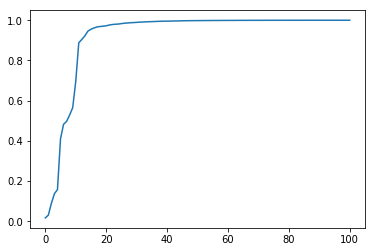

In [20]:
fitness_fn=[Rastrigin, Rosenbrock, Ackley]
rst=[5.12, 2.048, 32.768]  # Para restringir el espacio de busqueda de la poblacion entre [-rst,rst] 


# parametros del AG
num_individuals=20
ngen = 100 #Max NumGenerations
pmut   = 0.9 #prb. mutation
metodoSeleccion=['roulette','torneo'] 
crossover=['onepoint','uniform']
mutation=['position','allpositions']
size_torneo = int(5*num_individuals/100) #tamaño del torneo como 5% del tamaño de la poblacion


# Inicializa una poblacion inicial de forma aleatoria
population = init_population(num_individuals, rst[0])

# Ejecuta la optimizacion con el AG
best_ind, best_fitness, best_chromosoma = genetic_algorithm(population, fitness_fn[0],  # Rastrigin
                                                            ngen, metodoSeleccion[0],   # ruleta
                                                            size_torneo, pmut,
                                                            crossover[1], mutation[1])  # crossover uniform, muation position
                                                            
plt.plot(best_fitness)                
plt.show()

In [ ]:
print(" best_fitness = {}, best_chromosoma = {}".format(best_ind.fitness,best_ind.chromosome))